# Assignment 10 - UNet

In this assignement we are going to program our own UNet network (https://arxiv.org/pdf/1505.04597.pdf) which is a simple but powerful one. This network is made to produce a segmentation map. This segmentation map can be a little bit smaller than the true map but keep the same spatial structure. This map however is composed of several layers, one per class. The goal for the network is to activate pixel-wisely a layer if the pixel are representing the object of the layer.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png", width=700)

The network look this way. The descending part is simply made out of convolution layer and pooling, easy peasy. This part of the network allow a move from the "Where?" information to the "What?" information. Then the informations are spatially dilated through a so called "transpose convolution" looking like a convoltuion mixed with an inverse pooling and then you convolute. as I sayed above, there is one layer of exit per class, don't trust the drawing, the initial version of this network was only design to say yes or not (That why there is two output layer)

In [2]:
Image(url= "https://miro.medium.com/max/3200/0*mk6U6zQDuoQLK7Ca", width=700)

After each big step of convolution, the informations are stacked to the last part of the network (grey arrow) reinjecting this way the "Where?" information.

# 8.1

Yo have to reproduce this network by yourself. The images takken for this work come from the PascalVOC database (http://host.robots.ox.ac.uk/pascal/VOC/). Here you inject RGB images into your network and out a "cube" of maps. The label of the data are on the shape of images with one channel, the background is represented by 0 and the differents class by a unique label (all the pixel filled out of ones are representing a plan typically.)

You have to use dtype=torch.float32 for the images and dtype=torch.long for the mask and every thing should run perfectly. Use also the criterion to use should be criterion = nn.CrossEntropyLoss() because he can understand the type of label injected (https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss). 

Try to work on this early, the training can be slow (like 1h for 50 epoch ; batch : 100)

In [3]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import torch
import torchvision
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from tqdm import tqdm
from torch.autograd import Function
from torch.utils.data import DataLoader, random_split
from torchvision import models
from matplotlib import pyplot as plt
from PIL import Image

### Load Dataset & calculate class weights

Most of the targets are 0, i.e. no class. The network will therefore only learn to predict "no class" and achieve an accuracy of 70%. We deal with this issue by counting the instances of each class and setting the weights for the CrossEntropyLoss accordingly

In [4]:
from collections import Counter

class VOCSegLoader(torchvision.datasets.VOCSegmentation):
    def __init__(self, 
                 root, 
                 year='2012',
                 image_set='train',
                 download=False,
                 transform=None,
                 target_transform=None,
                 transforms=None):
        
        super(VOCSegLoader, self).__init__(root, year, image_set, download, transform, target_transform, transforms)
        self.weights = self.compute_weights()
        
    def compute_weights(self):
        return {} # TODO: remove
        ctr = Counter()
        
        for m in self.masks:
            target = np.array(Image.open(m)).reshape(-1)
            ctr.update(target)
        
        total = sum(ctr.values())
        weights = dict(ctr)
        weights[0] += weights[255]
        del weights[255]
        
        for k in weights:
            weights[k] = total / weights[k]
            
        return weights
    
    def get_per_class_weights(self):
        # TODO: remove
        return torch.as_tensor(np.array([1.3367, 147.4030,  21.8795, 111.7227,  91.7352,  60.4064, 117.5779,
        172.9932, 173.3274,  77.6142,  65.8753,  90.8603, 114.9268, 127.3519,
         75.1020, 346.1150,  38.8689,  72.6595,  59.9830, 157.1314, 116.4192]), dtype=torch.float)
    
#         return torch.as_tensor(np.array(list(self.weights.values()), dtype=np.float), dtype=torch.float)


    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is the image segmentation.
        """
        img = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.masks[index])
        
        target = np.array(target)
        target[target == 255] = 0
        
        target = Image.fromarray(target)
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        target = torch.as_tensor(np.asarray(target, dtype=np.uint8), dtype=torch.long)
        return img, target

In [5]:
n_epochs = 3
batch_size_train = 1
# mini_batch_size_train = 16
batch_size_val = 16
learning_rate = 1e-2
momentum = 0.9
log_interval = 10
image_size = (64, 64)

transform_data = torchvision.transforms.Compose([torchvision.transforms.Resize(image_size), 
                                                 torchvision.transforms.ToTensor()])
transform_label = torchvision.transforms.Compose([torchvision.transforms.Resize(image_size, interpolation=0)])

In [6]:
train_dataset = VOCSegLoader('./data', year='2012', image_set='train', download=False,
                                         transform=transform_data, target_transform=transform_label)
val_dataset = VOCSegLoader('./data', year='2012', image_set='val', download=False,
                                         transform=transform_data , target_transform=transform_label)

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size_train)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size_val)

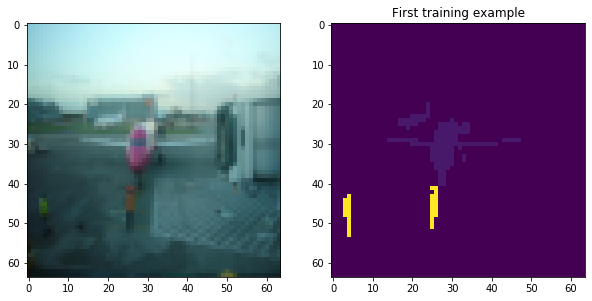

Labels: [0, 1, 15]


torch.Size([64, 64])

In [8]:
def show_example(title, image, target):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(np.asarray(image).transpose([1,2,0]))
    ax[1].imshow(np.asarray(target))
    plt.title(title)
    plt.show()
    
    print(f'Labels: {list(np.unique(target))}')

show_example('First training example', *train_dataset[0])
train_dataset[0][1].shape

## Transfer learning

This task is rather complex, so we might benefit from some good preinitialization. We noticed the first 10 layers of VGG are analogical, so we used those as our first contractive blocks

In [9]:
vgg = models.vgg16(pretrained=True)
first_vgg = list(vgg.children())[0]

first_vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [10]:
class Conv2dBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(Conv2dBlock, self).__init__()
        self.module = nn.Sequential(
            nn.Conv2d(channels_in, channels_out, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(channels_out),
            nn.Conv2d(channels_out, channels_out, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(channels_out)
        )

    def forward(self, x):
        return self.module(x)


class ContractiveBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(ContractiveBlock, self).__init__()
        self.cblock = Conv2dBlock(channels_in, channels_out)
        self.pool = nn.MaxPool2d((2, 2), stride=2)

    def forward(self, x):
        out1 = self.cblock(x)
        out2 = self.pool(out1)
        return out2, out1

class VGGContractiveBlock(nn.Module):
    def __init__(self, layers):
        super(VGGContractiveBlock, self).__init__()
        self.cblock = nn.Sequential(*layers[:3])
        self.pool = layers[4]
        
        for param in self.cblock.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        out1 = self.cblock(x)
        out2 = self.pool(out1)
        return out2, out1


class ExpansiveBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(ExpansiveBlock, self).__init__()
        self.tconv = nn.ConvTranspose2d(channels_in, channels_out, 2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.cblock = Conv2dBlock(channels_in, channels_out)

    def forward(self, x, y):
        x1 = self.relu(self.tconv(x))
        x2 = torch.cat([x1, y], dim=1)
        # why sigmoid? prev output already through relu
#         out = torch.sigmoid(self.cblock(x2))
        out = self.cblock(x2)
        return out


class UNet(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(UNet, self).__init__()
        # use vgg for first 2 contractive blocks
        self.cb1 = VGGContractiveBlock(first_vgg[:5])
        self.cb2 = VGGContractiveBlock(first_vgg[5:10])
        
        self.cb3 = ContractiveBlock(128, 256)
        self.cb4 = ContractiveBlock(256, 512)

        self.convb = Conv2dBlock(512, 1024)

        self.eb1 = ExpansiveBlock(1024, 512)
        self.eb2 = ExpansiveBlock(512, 256)
        self.eb3 = ExpansiveBlock(256, 128)
        self.eb4 = ExpansiveBlock(128, 64)

        self.conv = nn.Conv2d(64, channels_out, 1)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x1, y1 = self.cb1(x)
        x2, y2 = self.cb2(x1)
        x3, y3 = self.cb3(x2)
        x4, y4 = self.cb4(x3)
        x5 = self.convb(x4)
        x6 = self.eb1(x5, y4)
        x7 = self.eb2(x6, y3)
        x8 = self.eb3(x7, y2)
        x9 = self.eb4(x8, y1)
#         out = F.sigmoid(self.conv(x9))
        out = self.sm(self.conv(x9))
        return out

In [11]:
train_dataset.get_per_class_weights()

tensor([  1.3367, 147.4030,  21.8795, 111.7227,  91.7352,  60.4064, 117.5779,
        172.9932, 173.3274,  77.6142,  65.8753,  90.8603, 114.9268, 127.3519,
         75.1020, 346.1150,  38.8689,  72.6595,  59.9830, 157.1314, 116.4192])

In [12]:
def runtrain(model, data, validation=None, optimizer=None, scheduler=None, max_epochs=1000):
    model.train()
    criterion = nn.CrossEntropyLoss(weight=train_dataset.get_per_class_weights().cuda())
    optimizer = optimizer or torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    should_validate = not (validation is None)

    losses = []
    step = 0
    for t in range(max_epochs):
        sum_loss = 0
        batch_count = 0
        for x_, y_ in data:
            if should_validate:
                loader_test = iter(validation)
                x_test, y_test = next(loader_test)
                x_test = x_test.cuda()
                y_test = y_test.cuda()
                y_test = y_test.reshape([-1])
                y_pred_test = model.forward(x_test).permute(0,2,3,1).reshape([-1, 21])
                accuracy_test = (torch.argmax(y_pred_test, dim=1) == y_test).sum().item() / len(y_test)

            optimizer.zero_grad()
            x_ = x_.cuda()
            y_ = y_.cuda()
            y_pred = model.forward(x_)
            loss = criterion(y_pred, y_)
            loss.backward()
            optimizer.step()

            y_ = y_.reshape([-1])
            y_pred = y_pred.permute(0,2,3,1).reshape([-1, 21])
            accuracy = (torch.argmax(y_pred, dim=1) == y_).sum().item() / len(y_)
            sum_loss += loss
            batch_count += 1
            avg_loss = sum_loss / batch_count
            step += 1

            if scheduler:
                learning_rate = np.mean(scheduler.get_lr())
            if should_validate:
                sys.stdout.write("\rEpoch: {}, Step: {}, Loss: {:.10f}, Learning rate: {:.10f}, Accuracy: {:.2%}, Validation accuracy: {:.2%}".format(t+1, step, avg_loss, learning_rate, accuracy, accuracy_test))
            else:
                sys.stdout.write("\rEpoch: {}, Step: {}, Loss: {:.10f}, Learning rate: {:.10f}, Accuracy: {:.2%}".format(t+1, step, avg_loss, learning_rate, accuracy))

        if scheduler:
            scheduler.step()

        avg_loss = avg_loss / batch_count
        losses.append(avg_loss.item())

    return losses

In [13]:
unet = UNet(3, 21)
unet.cuda()

optimizer = torch.optim.SGD(unet.parameters(), lr=1e-2, momentum=0.99)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

runtrain(unet, train_loader, validation=val_loader, optimizer=optimizer, max_epochs=5, scheduler=exp_lr_scheduler) # ,scheduler=exp_lr_scheduler

Epoch: 5, Step: 7320, Loss: 2.8882482052, Learning rate: 0.0000010000, Accuracy: 64.94%, Validation accuracy: 53.65%

[0.001997436862438917,
 0.0019772546365857124,
 0.0019735614769160748,
 0.001972923055291176,
 0.0019728471525013447]

In [14]:
def predict(model, img):
    model_out = model.forward(img)
    prediction = torch.argmax(model_out.permute(0, 2, 3, 1).reshape([-1, 21]), dim=1).reshape([16,64,64])
    return prediction
    
data, target = iter(val_loader).next()
prediction = predict(unet, data.cuda())

In [15]:
def view_at_index(data, target, prediction, i):
    show_example(f'Target at i={i}', data[i], target[i])
    
    mask = prediction[i].detach().cpu().numpy()
    show_example(f'Prediction at i={i}', data[i], mask)

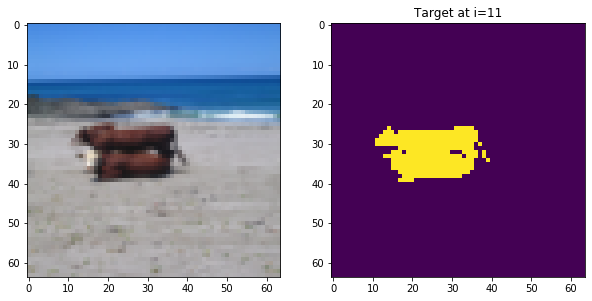

Labels: [0, 10]


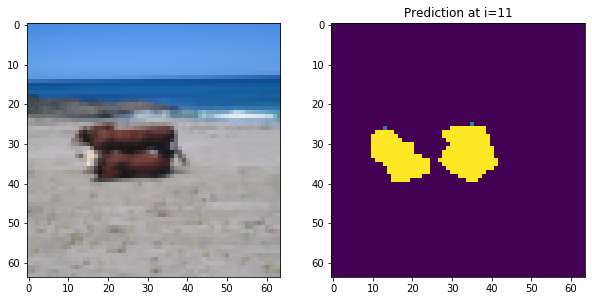

Labels: [0, 7, 15]


In [16]:
view_at_index(data, target, prediction, 11)

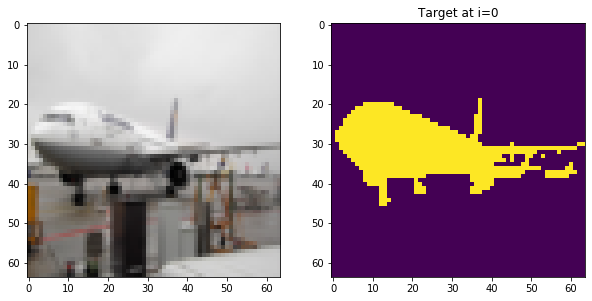

Labels: [0, 1]


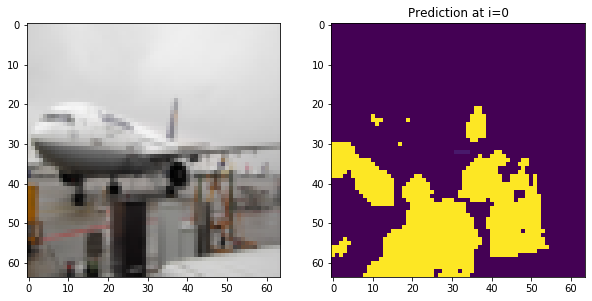

Labels: [0, 1, 15]


In [19]:
view_at_index(data, target, prediction, 0)

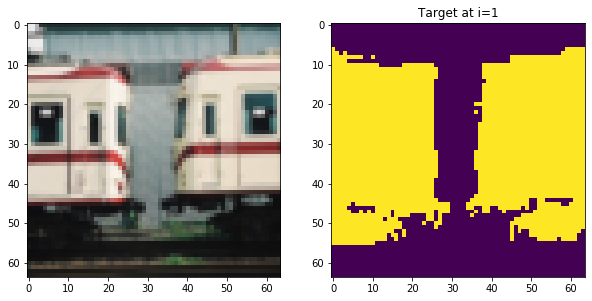

Labels: [0, 19]


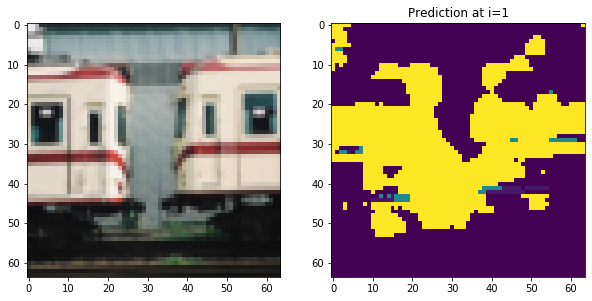

Labels: [0, 1, 7, 15]


In [20]:
view_at_index(data, target, prediction, 1)

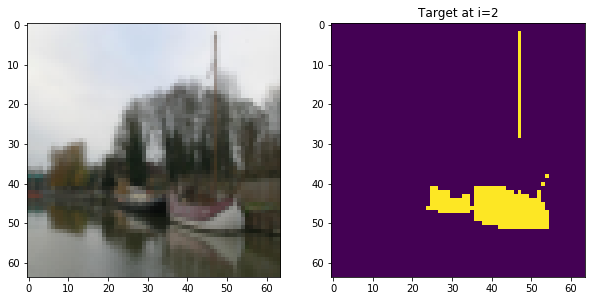

Labels: [0, 4]


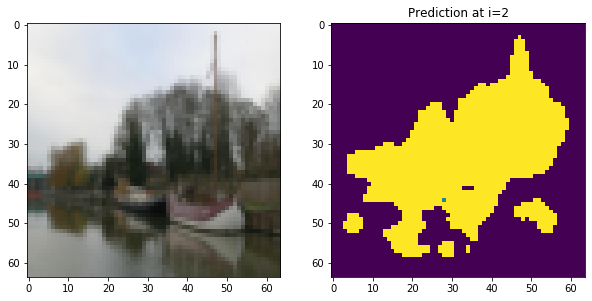

Labels: [0, 7, 15]


In [21]:
view_at_index(data, target, prediction, 2)

## 8.2
Once you have done that, we want you to redesign a network where you remove to reinjection link (grey arrow on the drawing). You can remove the both from your choice just try and tell us if it's still working and why.

In [17]:
class Conv2dBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(Conv2dBlock, self).__init__()
        self.module = nn.Sequential(
            nn.Conv2d(channels_in, channels_out, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(channels_out),
            nn.Conv2d(channels_out, channels_out, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(channels_out)
        )

    def forward(self, x):
        return self.module(x)


class ContractiveBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(ContractiveBlock, self).__init__()
        self.cblock = Conv2dBlock(channels_in, channels_out)
        self.pool = nn.MaxPool2d((2, 2), stride=2)

    def forward(self, x):
        out1 = self.cblock(x)
        out2 = self.pool(out1)
        return out2, out1

class VGGContractiveBlock(nn.Module):
    def __init__(self, layers):
        super(VGGContractiveBlock, self).__init__()
        self.cblock = nn.Sequential(*layers[:3])
        self.pool = layers[4]
        
        for param in self.cblock.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        out1 = self.cblock(x)
        out2 = self.pool(out1)
        return out2, out1


class ExpansiveBlockNoInjection(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(ExpansiveBlock, self).__init__()
        self.tconv = nn.ConvTranspose2d(channels_in, channels_out, 2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.cblock = Conv2dBlock(channels_in, channels_out)

    def forward(self, x, y):
        x1 = self.relu(self.tconv(x))
        out = self.cblock(x1)
        return out


class UNetNoInjection(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(UNet, self).__init__()
        # use vgg for first 2 contractive blocks
        self.cb1 = VGGContractiveBlock(first_vgg[:5])
        self.cb2 = VGGContractiveBlock(first_vgg[5:10])
        
        self.cb3 = ContractiveBlock(128, 256)
        self.cb4 = ContractiveBlock(256, 512)

        self.convb = Conv2dBlock(512, 1024)

        self.eb1 = ExpansiveBlockNoInjection(1024, 512)
        self.eb2 = ExpansiveBlockNoInjection(512, 256)
        self.eb3 = ExpansiveBlockNoInjection(256, 128)
        self.eb4 = ExpansiveBlockNoInjection(128, 64)

        self.conv = nn.Conv2d(64, channels_out, 1)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x1, y1 = self.cb1(x)
        x2, y2 = self.cb2(x1)
        x3, y3 = self.cb3(x2)
        x4, y4 = self.cb4(x3)
        x5 = self.convb(x4)
        x6 = self.eb1(x5, y4)
        x7 = self.eb2(x6, y3)
        x8 = self.eb3(x7, y2)
        x9 = self.eb4(x8, y1)
#         out = F.sigmoid(self.conv(x9))
        out = self.sm(self.conv(x9))
        return out

In [ ]:
unet_no_inject = UNetNoInjection(3, 21)
unet_no_inject.cuda()

optimizer = torch.optim.SGD(unet.parameters(), lr=learning_rate, momentum=momentum)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

losses_no_inject = runtrain(unet_no_inject, train_loader, validation=val_loader, optimizer=optimizer, scheduler=exp_lr_scheduler, max_epochs=100)